In [1]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from google.colab import drive
import gdown
import json

# ----------------------------------------
# Check GPU
# ----------------------------------------
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

-------------------
!pip install -q torch torchvision kaggle gdown

GPU Available: True
GPU Name: Tesla T4
Using device: cuda


In [ ]:
# ----------------------------------------
# Step 1: Install and import required packages
# (if using Colab, some packages like kaggle may need to be installed first)
# ----------------------------------------
!pip install kaggle --quiet  # Install Kaggle API client
!pip install umap-learn --quiet  # For UMAP dimensionality reduction

import os  # For file and directory operations
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from sklearn.preprocessing import StandardScaler  # For scaling gene expression data

In [2]:
# Setup Kaggle API (environment variables recommended)
# ----------------------------------------
os.environ["KAGGLE_USERNAME"] = "your_username"
os.environ["KAGGLE_KEY"] = "your_api_key"
kaggle_username = os.environ.get("KAGGLE_USERNAME")
kaggle_key      = os.environ.get("KAGGLE_KEY")
if kaggle_username and kaggle_key:
    os.makedirs("/root/.kaggle", exist_ok=True)
    with open("/root/.kaggle/kaggle.json", "w") as f:
        json.dump({"username": kaggle_username, "key": kaggle_key}, f)
    os.chmod("/root/.kaggle/kaggle.json", 0o600)
    !kaggle -v
else:
    print("⚠️ Kaggle credentials not set. Set KAGGLE_USERNAME and KAGGLE_KEY env variables.")




Kaggle API 1.7.4.5


In [3]:
# Download METABRIC breast cancer dataset from Kaggle
# Dataset contains gene expression and clinical data
# ----------------------------------------
!kaggle datasets download -d raghadalharbi/breast-cancer-gene-expression-profiles-metabric

# Step 4: Unzip the downloaded dataset
# This will extract CSV or TSV files for further analysis
!unzip breast-cancer-gene-expression-profiles-metabric.zip

Dataset URL: https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric
License(s): DbCL-1.0
  0% 0.00/2.72M [00:00<?, ?B/s]
100% 2.72M/2.72M [00:00<00:00, 795MB/s]
Archive:  breast-cancer-gene-expression-profiles-metabric.zip
  inflating: METABRIC_RNA_Mutation.csv  


In [5]:
#Load clinical and gene expression data
# Assume files are named 'clinical.csv' and 'gene_expression.csv' after extraction

clinical = pd.read_csv("METABRIC_RNA_Mutation.csv")
clinical.head()


/tmp/ipython-input-4154019715.py:3: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [6]:
!ls


breast-cancer-gene-expression-profiles-metabric.zip  sample_data
METABRIC_RNA_Mutation.csv


In [9]:


df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df.head()


/tmp/ipython-input-1034879137.py:3: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.columns


Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=693)

In [11]:
clinical_cols = [
    "age_at_diagnosis",
    "overall_survival",
    "overall_survival_months",
    "cancer_type_detailed"
]

clinical = df[clinical_cols].dropna()
clinical.head()


,age_at_diagnosis,overall_survival,overall_survival_months,cancer_type_detailed
0,75.65,1,140.500000,Breast Invasive Ductal Carcinoma
1,43.19,1,84.633333,Breast Invasive Ductal Carcinoma
2,48.87,0,163.700000,Breast Invasive Ductal Carcinoma
3,47.68,1,164.933333,Breast Mixed Ductal and Lobular Carcinoma
4,76.97,0,41.366667,Breast Mixed Ductal and Lobular Carcinoma


In [12]:

# Select only gene expression columns
# Assume gene expression starts from column index 31 onwards
# Align rows with the clinical data
# ----------------------------------------
gene_expression = df.iloc[:, 31:]
gene_expression = gene_expression.loc[clinical.index]
# Preview the first 5 rows
gene_expression.head()


,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,0,0,0,0,0,0,0,0,0,0
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,0,0,0,0,0,0,0,0,0,0
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,0,0,0,0,0,0,0,0,0,0
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,0,0,0,0,0,0,0,0,0,0
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,0,0,0,0,0,0,0,0,0,0


In [13]:
gene_expression.dtypes.value_counts()

,count
float64,489
object,173


In [14]:

# Keep only numeric gene expression columns
gene_expression_numeric = gene_expression.select_dtypes(include=["int64", "float64"])
gene_expression_numeric.shape


(1889, 489)

In [15]:
gene_expression_numeric = gene_expression_numeric.dropna(axis=1)# Drop columns with NaNs


In [16]:

# ----------------------------------------
# Scale gene expression data
# StandardScaler centers the data (mean=0) and scales to unit variance
# ----------------------------------------
scaler = StandardScaler()
X_genes_scaled = scaler.fit_transform(gene_expression_numeric)


In [ ]:


# Copy clinical data to create age groups
clinical_age = clinical.copy()

clinical_age["age_group"] = np.nan
clinical_age.loc[clinical_age["age_at_diagnosis"] <= 40, "age_group"] = "Early"
clinical_age.loc[clinical_age["age_at_diagnosis"] >= 60, "age_group"] = "Late"

# Keep only Early and Late age groups
mask = clinical_age["age_group"].isin(["Early", "Late"])
clinical_age = clinical_age[mask]
gene_expression_age = gene_expression_numeric.loc[clinical_age.index]

clinical_age["age_group"].value_counts()


/tmp/ipython-input-2152411666.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Early' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clinical_age.loc[clinical_age["age_at_diagnosis"] <= 40, "age_group"] = "Early"


,count
age_group,
Late,1054
Early,116


In [ ]:
clinical_age[["age_group", "overall_survival", "overall_survival_months"]].head()


,age_group,overall_survival,overall_survival_months
0,Late,1,140.500000
4,Late,0,41.366667
5,Late,0,7.800000
7,Late,0,99.533333
8,Late,0,36.566667


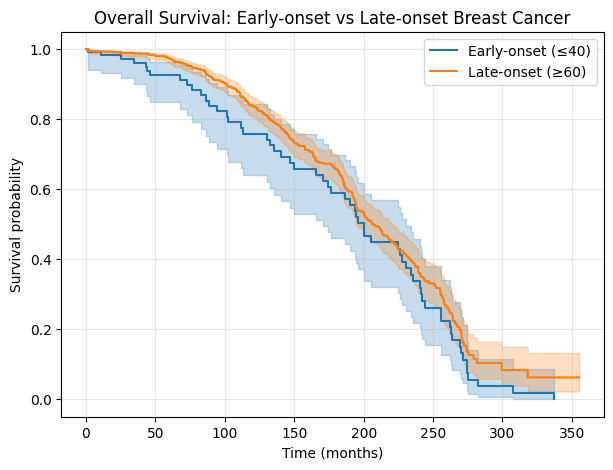

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(7,5))

for group, label in zip(["Early", "Late"], ["Early-onset (≤40)", "Late-onset (≥60)"]):
    mask = clinical_age["age_group"] == group
    kmf.fit(
        durations=clinical_age.loc[mask, "overall_survival_months"],
        event_observed=clinical_age.loc[mask, "overall_survival"],
        label=label
    )
    kmf.plot_survival_function(ci_show=True)

plt.title("Overall Survival: Early-onset vs Late-onset Breast Cancer")
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from lifelines.statistics import logrank_test

early = clinical_age["age_group"] == "Early"
late  = clinical_age["age_group"] == "Late"

results = logrank_test(
    clinical_age.loc[early, "overall_survival_months"],
    clinical_age.loc[late, "overall_survival_months"],
    event_observed_A=clinical_age.loc[early, "overall_survival"],
    event_observed_B=clinical_age.loc[late, "overall_survival"]
)

results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.80 0.09      3.41

In [ ]:
from lifelines import CoxPHFitter

cox_df = clinical_age[[
    "overall_survival",
    "overall_survival_months",
    "age_group"
]].copy()

# Encode age_group
cox_df["age_group_binary"] = (cox_df["age_group"] == "Late").astype(int)

cph = CoxPHFitter()
cph.fit(
    cox_df[["overall_survival", "overall_survival_months", "age_group_binary"]],
    duration_col="overall_survival_months",
    event_col="overall_survival"
)

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1170 total observations, 796 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'overall_survival'
      baseline estimation = breslow
   number of observations = 1170
number of events observed = 374
   partial log-likelihood = -2104.67
         time fit was run = 2025-12-17 17:17:37 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
age_group_binary -0.24      0.79      0.14           -0.52            0.04                0.59                1.04

                  cmp to     z    p  -log2(p)
covariate                                    
age_group_binary    0.00 -1.67 0.10      3.40
---
Concordance = 0.52
Partial AIC = 4211.35
log-likelihood ratio test = 2.65 on 1 df
-log2(p) of ll-ratio test = 3.27

In [ ]:
# ========================================
# Autoencoder for gene expression compression
# ========================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z
# ========================================
# Train autoencoder
# ========================================
model = Autoencoder(input_dim=X_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [ ]:
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

for epoch in range(30):
    for batch in loader:
        x = batch[0]
        recon, _ = model(x)
        loss = criterion(recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
# ========================================
# Extract latent features and survival modeling
# ========================================
with torch.no_grad():
    _, Z = model(X_tensor)

Z = Z.numpy()


In [ ]:
latent_df = pd.DataFrame(Z, index=clinical_age.index)
latent_df["overall_survival"] = clinical_age["overall_survival"]
latent_df["overall_survival_months"] = clinical_age["overall_survival_months"]

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(latent_df, duration_col="overall_survival_months",
        event_col="overall_survival")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1170 total observations, 796 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'overall_survival'
      baseline estimation = breslow
   number of observations = 1170
number of events observed = 374
   partial log-likelihood = -2017.60
         time fit was run = 2025-12-17 17:21:41 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
0          0.00      1.00      0.04           -0.08            0.08                0.92                1.08
1          0.03      1.03      0.04           -0.06            0.11                0.94                1.12
2          0.11      1.12      0.04            0.03            0.19                1.03                1.21
3          0.04      1.04      0.04           -0.05            0.12                0.95                1.13
4          0.09      1.10      0.04            0.01            0.18                1.01                1.20
5          0.05      1.05      0.05           -0.04            0.14                0.96                1.15
6         -0.03      0.97      0.05           -0.12            0.06                0.89                1.07
7         -0.04      0.96      0.04           -0.12            0.04                0.89                1.05
8         -0.10      0.91      0.05           -0.19           -0.01                0.83                0.99
9          0.07      1.07      0.04           -0.02            0.15                0.98                1.16
10        -0.09      0.92      0.04           -0.17           -0.00                0.84                1.00
11         0.04      1.04      0.04           -0.04            0.12                0.96                1.12
12         0.03      1.03      0.04           -0.06            0.11                0.95                1.12
13        -0.07      0.93      0.04           -0.16            0.01                0.85                1.01
14        -0.07      0.93      0.04           -0.15            0.02                0.86                1.02
15        -0.05      0.95      0.04           -0.13            0.04                0.87                1.04
16        -0.11      0.90      0.04           -0.19           -0.02                0.83                0.98
17         0.00      1.00      0.04           -0.08            0.09                0.92                1.09
18        -0.02      0.98      0.05           -0.11            0.07                0.90                1.07
19         0.03      1.03      0.04           -0.05            0.12                0.95                1.13
20         0.05      1.05      0.04           -0.03            0.13                0.97                1.14
21         0.04      1.04      0.04           -0.05            0.12                0.95                1.13
22        -0.04      0.96      0.04           -0.13            0.05                0.88                1.05
23        -0.17      0.85      0.05           -0.26           -0.08                0.77                0.92
24         0.12      1.13      0.04            0.04            0.20                1.04                1.22
25         0.04      1.04      0.04           -0.04            0.12                0.96                1.13
26         0.07      1.07      0.05           -0.02            0.16                0.98                1.17
27         0.00      1.00      0.05           -0.09            0.09                0.92                1.10
28        -0.03      0.97      0.04           -0.11            0.04                0.90                1.04
29        -0.23      0.80      0.04           -0.32           -0.14                0.73                0.87
30         0.10      1.10      0.05            0.01            0.19                1.01                1.21
31         0.10      1.10      0.05           